In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import math

In [4]:
all_epsilons = [1,2,3,4,5,10,50,100,500,1000]

In [5]:
data = [[50,10],[60,12],[59,15],[64,16],[68,18],[73,23],[71,23.5],[75,24],[80,36],[85,43],[84,45],[88,49],[91,56],[95,69],[97,78],[98,86],[97.5,87],[98.5,91],[99,96],[99.2,98],[99.3,99],[99.5,100]]
len(data)

22

In [6]:
my_pareto_front = pareto_front_from_model_zoo(data)
print(len(my_pareto_front))
print(type(my_pareto_front))

18
<class 'numpy.ndarray'>


In [7]:
# for every query, private models should be high_utility otherwise, what is the point of protecting them?
# the probability of heads = selecting public model. If this decreases, then the probability of selecting private model increases and utility should increase

# this is uniform sampling of public models from the pareto-front
public_models = my_pareto_front[::2]
private_models = my_pareto_front[1::2]

In [8]:
random.seed(42)
# this can be replaced with target model's accuracy / latency tuple, so that queries are to be routed to target model probabilistically. 
queries = [(random.randint(50, 100), random.randint(10, 100)) for _ in range(4000)] 

In [9]:
def PoissonSample(pareto_front, gamma):
    # select model from pareto front based on bernoulli trial using gamma
    # gamma is the probability of selecting a public model

    public_models = []
    private_models = []

    for model in pareto_front:
        if random.random() < gamma:
            public_models.append(model)
        else:
            private_models.append(model)
    
    return public_models, private_models

In [10]:
def public_private(start_eps, curr_eps, public_models, private_models, acc_input, lat_input, pvt_query, mechanism):
    
    # public_indices = np.arange(len(public_models))
    # np.random.shuffle(public_indices)

    # private_indices = np.arange(len(private_models))
    # np.random.shuffle(private_indices)

    # slide 13 in https://cs-people.bu.edu/gaboardi/teaching/cse660-Fall17/CSE660-19.pdf
    # with increasing eps, the probability of selecting public models increases
    prob_val = math.exp(start_eps) / (1 + math.exp(start_eps))
    gamma = 0.4

    if np.random.rand() < prob_val:
        if mechanism == l1_exponential_mechanism:
            my_pmf = mechanism(eps=start_eps, pareto_front=public_models, sensitivity=1, acc_input=acc_input, lat_input=lat_input)
            selected_element = select_element_from_pmf(my_pmf)
        else:
            selected_element = mechanism(eps=start_eps, pareto_front=public_models, sensitivity=1, acc_input=acc_input, lat_input=lat_input)

        # selected_index = public_indices[0]
        # point = public_models[selected_index]

    elif np.random.rand() < prob_val:
        if mechanism == l1_exponential_mechanism:
            my_pmf = mechanism(eps=start_eps, pareto_front=public_models, sensitivity=1, acc_input=acc_input, lat_input=lat_input)
            selected_element = select_element_from_pmf(my_pmf)
        else:
            selected_element = mechanism(eps=start_eps, pareto_front=public_models, sensitivity=1, acc_input=acc_input, lat_input=lat_input)
    
    else:
        pvt_query+=1
        curr_eps = start_eps * math.sqrt(pvt_query) * math.log(1 + gamma * (math.exp(start_eps) - 1))
        # you don't feed different epsilons each query
        if mechanism == l1_exponential_mechanism:
            my_pmf = mechanism(eps=start_eps, pareto_front=private_models, sensitivity=1, acc_input=acc_input, lat_input=lat_input)
            selected_element = select_element_from_pmf(my_pmf)
        else:
            selected_element = mechanism(eps=start_eps, pareto_front=public_models, sensitivity=1, acc_input=acc_input, lat_input=lat_input)

        # selected_index = private_indices[0]
        # point = private_models[selected_index]
    
    return selected_element, pvt_query, curr_eps

In [11]:
def dist_utility_public_private(epsilon, query_list, public_models, private_models, mechanism):
    # print(f"computing goodput for {eps}")
    utility = 0
    answered_queries = 0
    pvt_query = 0
    curr_eps = epsilon
    plot_data = []
    for query in query_list:
        selected_element,new_pvt_query,reported_eps  = public_private(epsilon, curr_eps, public_models, private_models, query[0], query[1], pvt_query, mechanism)

        curr_eps = reported_eps
        pvt_query = new_pvt_query

        # we can get none when the query is infeasible, then no point will have a high enough probability to be selected
        if selected_element is not None:
            # print("print2",selected_element,type(selected_element))
            answered_queries += 1
            selected_element = str(selected_element)
            selected_element = list(selected_element.strip("[]").split())
            utility += l1_score(float(selected_element[0]), float(selected_element[1]), query[0], query[1])

            plot_data_elem = {'eps': curr_eps, 'num_answered_queries': answered_queries, 'utility': utility/answered_queries}
            plot_data.append(plot_data_elem)
    
    # return utility/len(query_list)
    # return utility/answered_queries
    return plot_data

In [12]:
eps_0_1_exp = dist_utility_public_private(0.1, queries, public_models, private_models, l1_exponential_mechanism)
eps_0_1_paf = dist_utility_public_private(0.1, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [13]:
eps_0_25_exp = dist_utility_public_private(0.25, queries, public_models, private_models, l1_exponential_mechanism)
eps_0_25_paf = dist_utility_public_private(0.25, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [14]:
eps_0_5_exp = dist_utility_public_private(0.5, queries, public_models, private_models, l1_exponential_mechanism)
eps_0_5_paf = dist_utility_public_private(0.5, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [15]:
eps_1_exp = dist_utility_public_private(1, queries, public_models, private_models, l1_exponential_mechanism)
eps_1_paf = dist_utility_public_private(1, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [16]:
# eps_1_min_prob = dist_utility_public_private(1, queries, public_models, private_models)
# eps_1_max_prob = dist_utility_public_private(1, queries, public_models, private_models)

In [17]:
eps_2_exp = dist_utility_public_private(2, queries, public_models, private_models, l1_exponential_mechanism)
eps_2_paf = dist_utility_public_private(2, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [18]:
eps_3_exp = dist_utility_public_private(3, queries, public_models, private_models, l1_exponential_mechanism)
eps_3_paf = dist_utility_public_private(3, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [19]:
eps_4_exp = dist_utility_public_private(4, queries, public_models, private_models, l1_exponential_mechanism)
eps_4_paf = dist_utility_public_private(4, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [20]:
eps_5_exp = dist_utility_public_private(5, queries, public_models, private_models, l1_exponential_mechanism)
eps_5_paf = dist_utility_public_private(5, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [21]:
eps_10_exp = dist_utility_public_private(10, queries, public_models, private_models, l1_exponential_mechanism)
eps_10_paf = dist_utility_public_private(10, queries, public_models, private_models, l1_permute_and_flip_mechanism)

In [22]:
def degrade_eps_plot(my_data, mechanism):
    num_answered_queries = [d['num_answered_queries'] for d in my_data]
    eps_values = [d['eps'] for d in my_data]
    utility_values = [d['utility'] for d in my_data]

    start_eps = eps_values[0]
    prob_public = math.exp(start_eps) / (1 + math.exp(start_eps))

    # Create the figure and primary y-axis
    fig, ax1 = plt.subplots()

    # Plot eps vs num_answered_queries
    ax1.plot(num_answered_queries, eps_values, label='eps', color='blue')
    ax1.set_xlabel('num_answered_queries')
    ax1.set_ylabel('eps', color='blue')

    # Create secondary y-axis
    ax2 = ax1.twinx()

    # Plot utility vs num_answered_queries
    ax2.plot(num_answered_queries, utility_values, label='utility', color='red')
    ax2.set_ylabel('utility', color='red')

    # Add legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    
    plt.title(f'start_eps = {start_eps}, prob_public = {round(prob_public,5)}, {len(queries)} queries, {mechanism.__name__}')
    plt.show()

In [23]:
def last_util_val(data):
    utility_values = [d['utility'] for d in data]
    return utility_values[-1]

In [24]:
def last_eps_val(data):
    eps_values = [d['eps'] for d in data]
    return eps_values[-1]

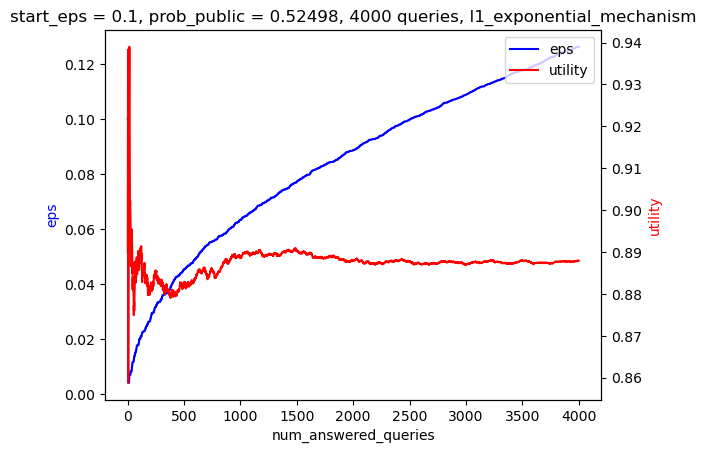

0.8879006249999959
0.12620548849485702


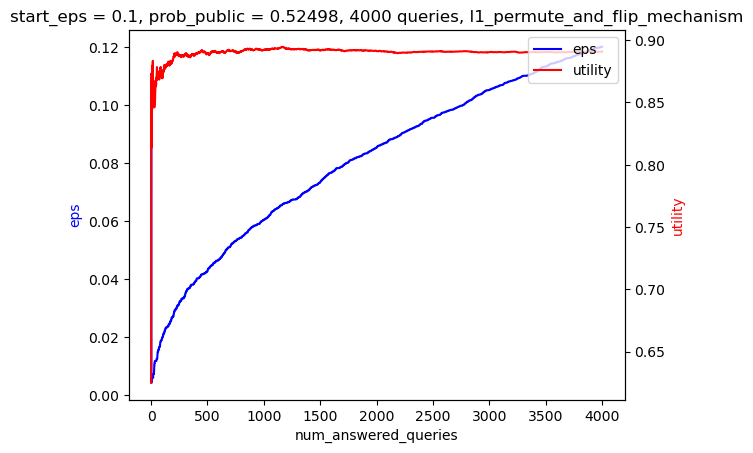

0.8907351249999983
0.12021027841622389


In [25]:
degrade_eps_plot(eps_0_1_exp, l1_exponential_mechanism)
print(last_util_val(eps_0_1_exp))
print(last_eps_val(eps_0_1_exp))
degrade_eps_plot(eps_0_1_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_0_1_paf))
print(last_eps_val(eps_0_1_paf))

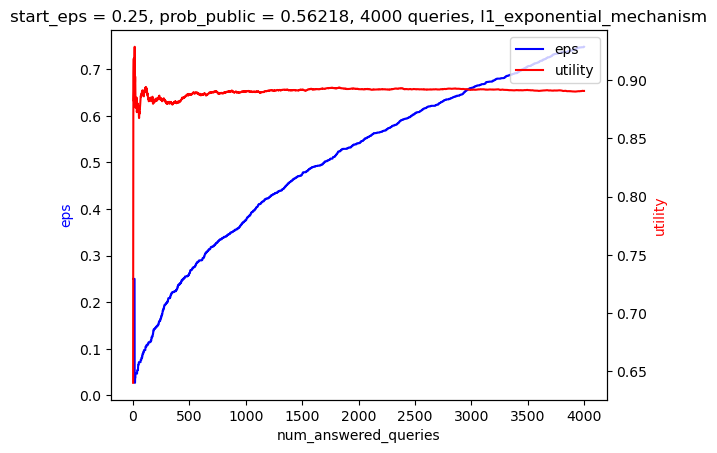

0.8907304999999969
0.7484306736045103


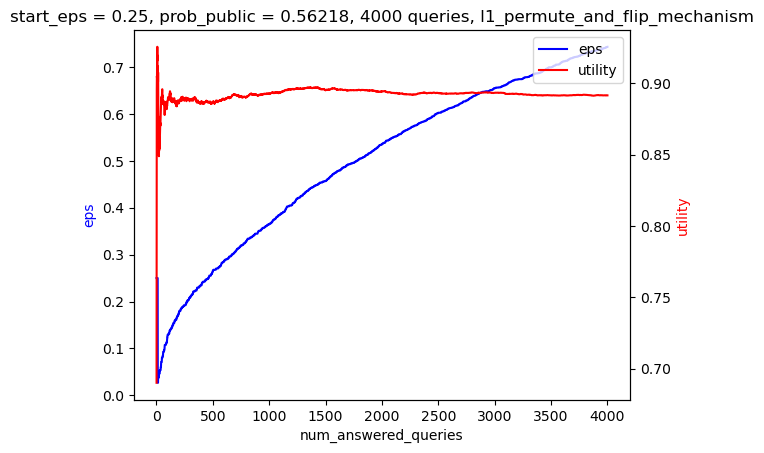

0.8915542499999974
0.7426062218561802


In [26]:
degrade_eps_plot(eps_0_25_exp, l1_exponential_mechanism)
print(last_util_val(eps_0_25_exp))
print(last_eps_val(eps_0_25_exp))
degrade_eps_plot(eps_0_25_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_0_25_paf))
print(last_eps_val(eps_0_25_paf))

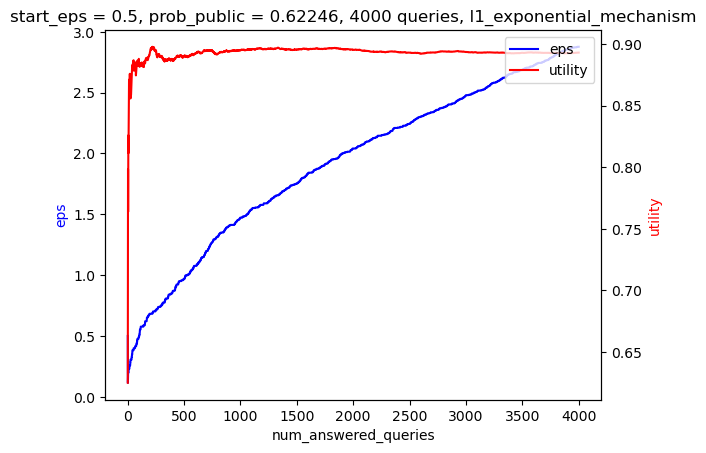

0.8930258749999979
2.876891663014993


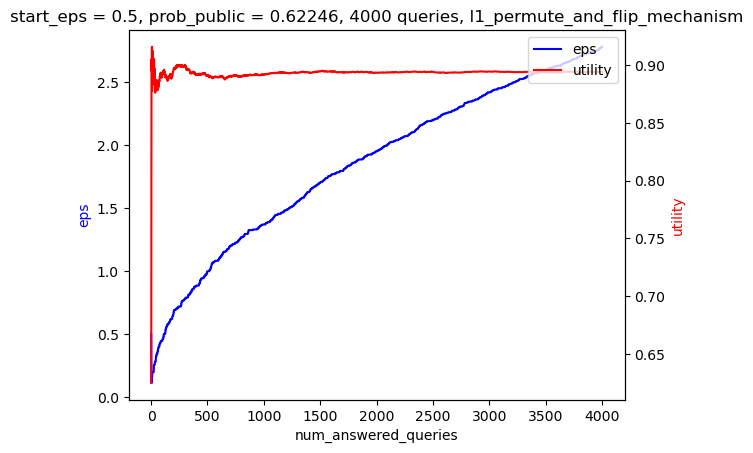

0.894048374999998
2.7780644189414954


In [27]:
degrade_eps_plot(eps_0_5_exp, l1_exponential_mechanism)
print(last_util_val(eps_0_5_exp))
print(last_eps_val(eps_0_5_exp))
degrade_eps_plot(eps_0_5_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_0_5_paf))
print(last_eps_val(eps_0_5_paf))

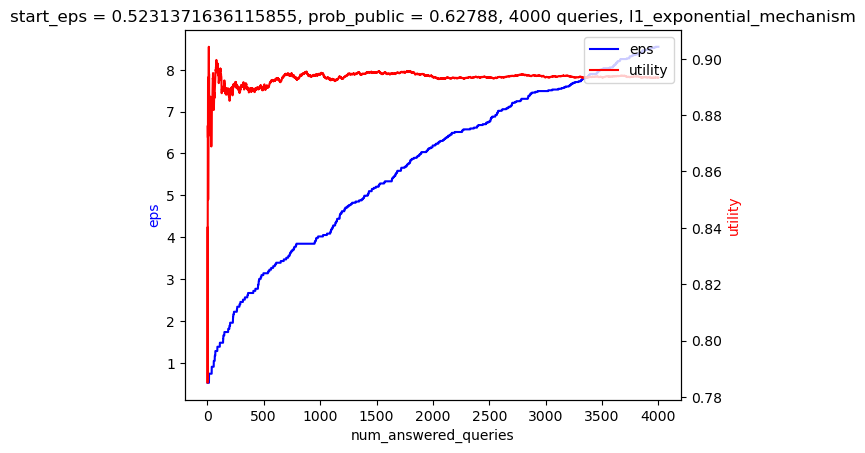

0.8933016249999971
8.548131687747356


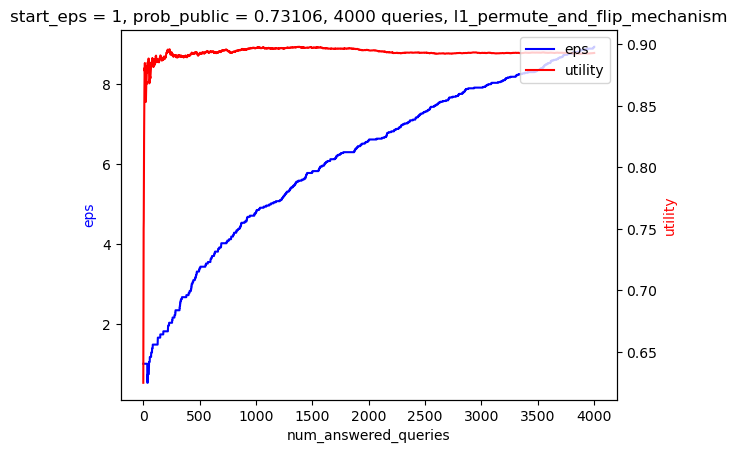

0.8928316249999998
8.939371770424351


In [28]:
degrade_eps_plot(eps_1_exp, l1_exponential_mechanism)
print(last_util_val(eps_1_exp))
print(last_eps_val(eps_1_exp))
degrade_eps_plot(eps_1_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_1_paf))
print(last_eps_val(eps_1_paf))

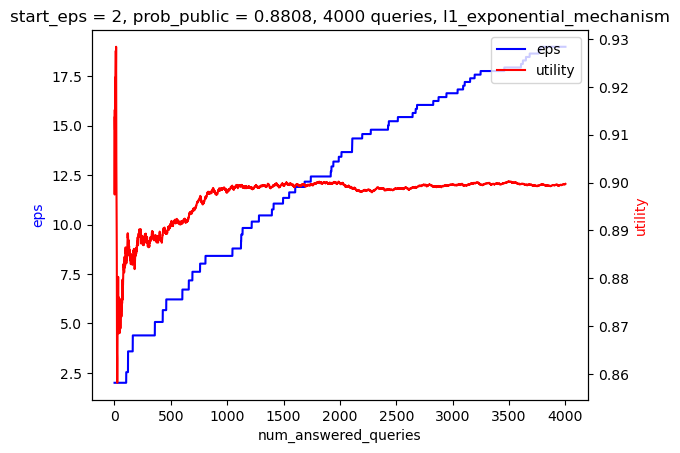

0.8997118749999957
18.985620621069295


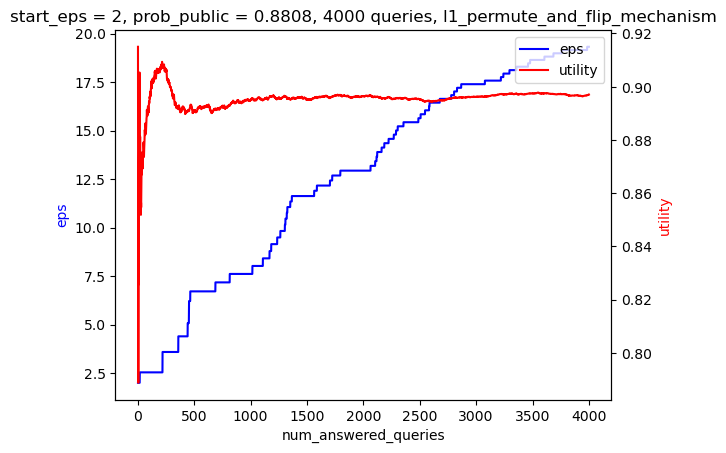

0.8970059999999959
19.32167539379394


In [29]:
degrade_eps_plot(eps_2_exp, l1_exponential_mechanism)
print(last_util_val(eps_2_exp))
print(last_eps_val(eps_2_exp))
degrade_eps_plot(eps_2_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_2_paf))
print(last_eps_val(eps_2_paf))

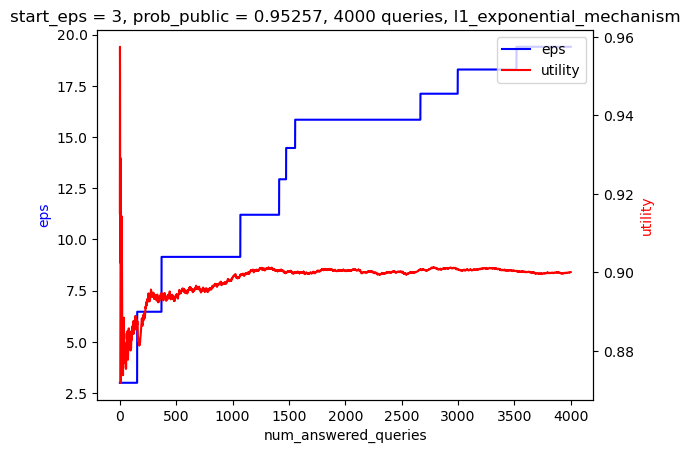

0.9000759999999969


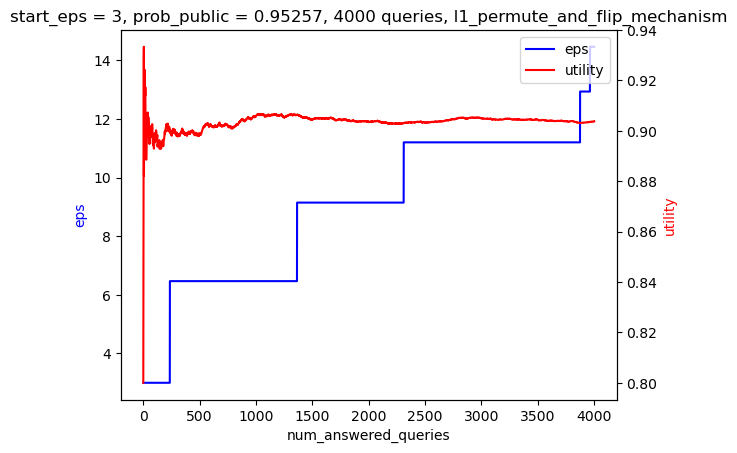

0.9037467499999957


In [30]:
degrade_eps_plot(eps_3_exp, l1_exponential_mechanism)
print(last_util_val(eps_3_exp))
degrade_eps_plot(eps_3_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_3_paf))

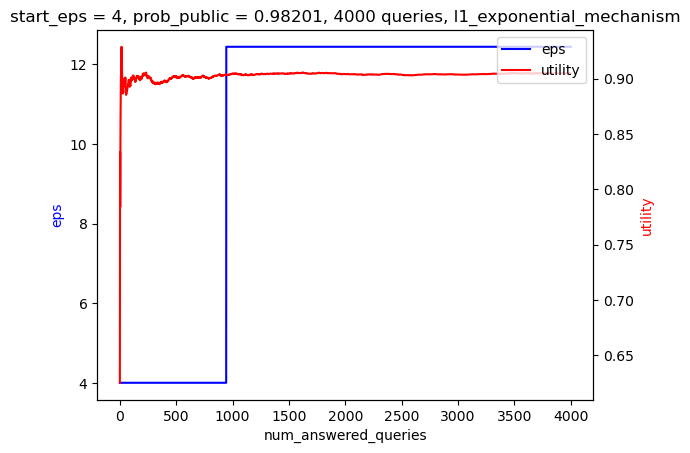

0.9048138749999963


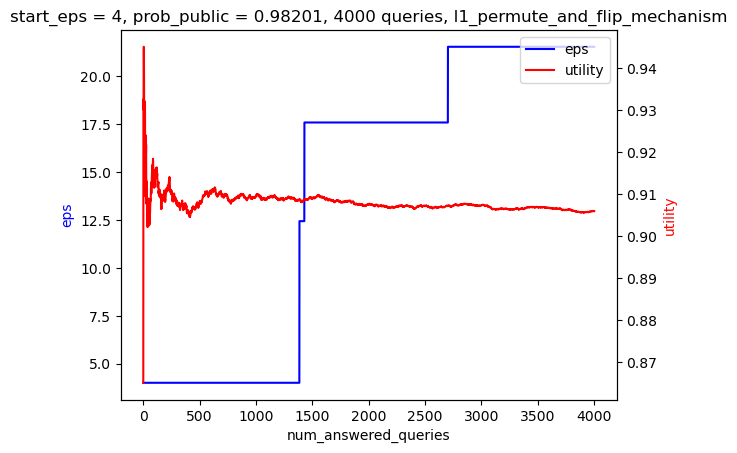

0.9058863749999971


In [31]:
degrade_eps_plot(eps_4_exp, l1_exponential_mechanism)
print(last_util_val(eps_4_exp))
degrade_eps_plot(eps_4_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_4_paf))

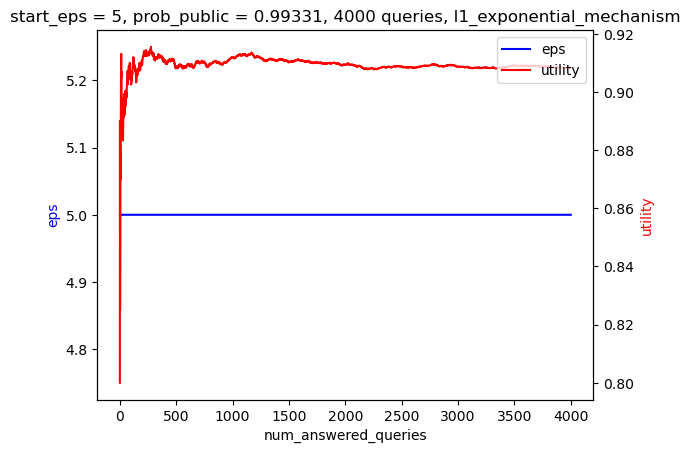

0.9083724999999971


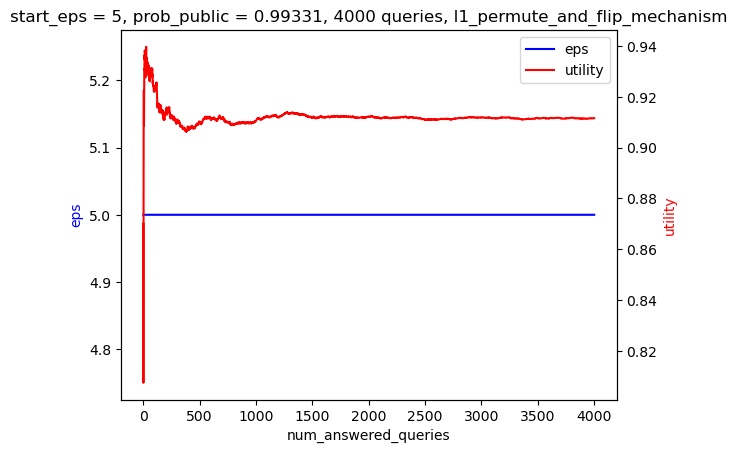

0.9115204999999962


In [32]:
degrade_eps_plot(eps_5_exp, l1_exponential_mechanism)
print(last_util_val(eps_5_exp))
degrade_eps_plot(eps_5_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_5_paf))

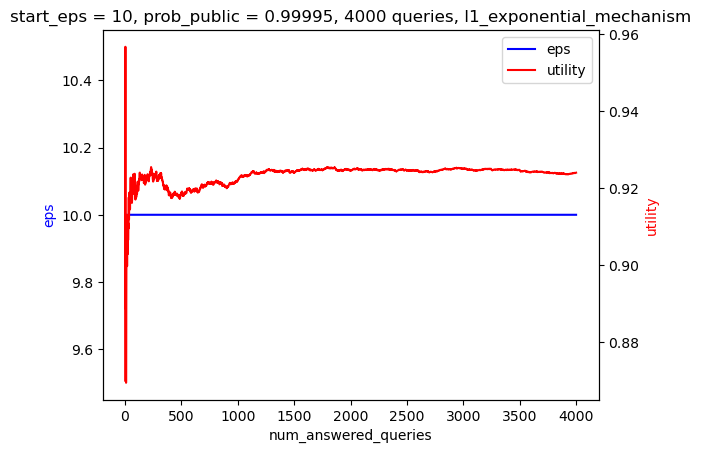

0.9239797499999948


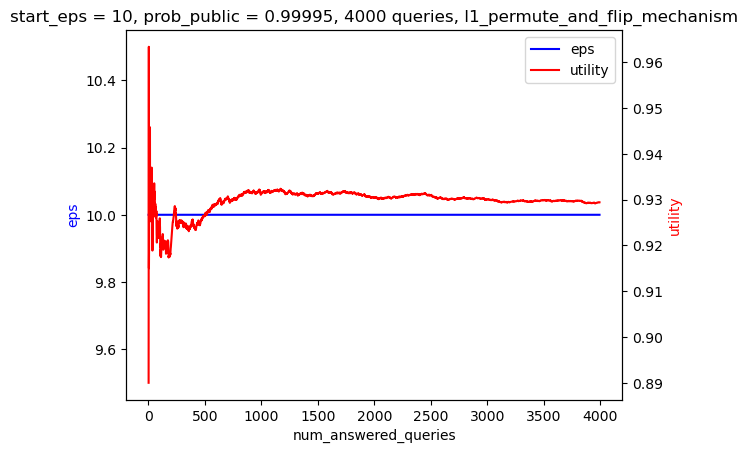

0.9293950926389529


In [33]:
degrade_eps_plot(eps_10_exp, l1_exponential_mechanism)
print(last_util_val(eps_10_exp))
degrade_eps_plot(eps_10_paf,l1_permute_and_flip_mechanism)
print(last_util_val(eps_10_paf))

In [34]:
# all_probs = np.arange(0.1, 1.0, 0.1)

In [35]:
dist_utility_l1_pnp = []
dist_utility_l1_pnp.append(last_util_val(eps_0_1_exp))
dist_utility_l1_pnp.append(last_util_val(eps_0_25_exp))
dist_utility_l1_pnp.append(last_util_val(eps_0_5_exp))
dist_utility_l1_pnp.append(last_util_val(eps_1_exp))
dist_utility_l1_pnp.append(last_util_val(eps_2_exp))
dist_utility_l1_pnp.append(last_util_val(eps_3_exp))
dist_utility_l1_pnp.append(last_util_val(eps_4_exp))
dist_utility_l1_pnp.append(last_util_val(eps_5_exp))
dist_utility_l1_pnp.append(last_util_val(eps_10_exp))


In [36]:
dist_utility_l1_pnp

[0.8879006249999959,
 0.8907304999999969,
 0.8930258749999979,
 0.8933016249999971,
 0.8997118749999957,
 0.9000759999999969,
 0.9048138749999963,
 0.9083724999999971,
 0.9239797499999948]

In [37]:
epsilons = [0.1,0.25,0.5,1,2,3,4,5,10]

In [38]:
dist_utility_l1_pnp_paf = []
dist_utility_l1_pnp_paf.append(last_util_val(eps_0_1_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_0_25_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_0_5_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_1_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_2_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_3_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_4_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_5_paf))
dist_utility_l1_pnp_paf.append(last_util_val(eps_10_paf))

In [39]:
dist_utility_l1_pnp_paf

[0.8907351249999983,
 0.8915542499999974,
 0.894048374999998,
 0.8928316249999998,
 0.8970059999999959,
 0.9037467499999957,
 0.9058863749999971,
 0.9115204999999962,
 0.9293950926389529]

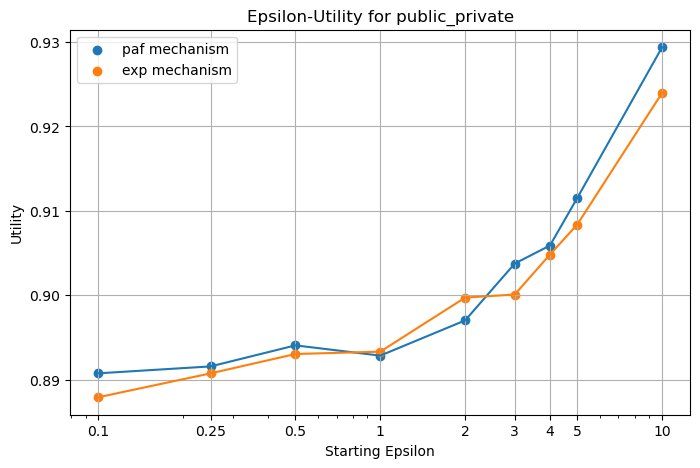

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(epsilons, dist_utility_l1_pnp_paf)
plt.scatter(epsilons, dist_utility_l1_pnp_paf, label="paf mechanism")
plt.plot(epsilons, dist_utility_l1_pnp)
plt.scatter(epsilons, dist_utility_l1_pnp, label="exp mechanism")
plt.xscale('log')
plt.xlabel('Starting Epsilon')
plt.ylabel('Utility')
plt.xticks(epsilons, [str(i) for i in epsilons])
plt.title(f'Epsilon-Utility for public_private')
plt.grid(True)
plt.legend()
plt.show()

In [41]:
dist_last_eps_l1_pnp = []
dist_last_eps_l1_pnp.append(last_eps_val(eps_0_1_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_0_25_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_0_5_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_1_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_2_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_3_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_4_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_5_exp))
dist_last_eps_l1_pnp.append(last_eps_val(eps_10_exp))


In [42]:
dist_last_eps_l1_pnp

[0.12620548849485702,
 0.7484306736045103,
 2.876891663014993,
 8.548131687747356,
 18.985620621069295,
 19.401594944877758,
 12.443248415497917,
 5,
 10]

In [43]:
dist_last_eps_l1_pnp_paf = []
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_0_1_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_0_25_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_0_5_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_1_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_2_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_3_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_4_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_5_paf))
dist_last_eps_l1_pnp_paf.append(last_eps_val(eps_10_paf))

In [44]:
dist_last_eps_l1_pnp_paf

[0.12021027841622389,
 0.7426062218561802,
 2.7780644189414954,
 8.939371770424351,
 19.32167539379394,
 14.461095056220984,
 21.55233846684332,
 5,
 10]

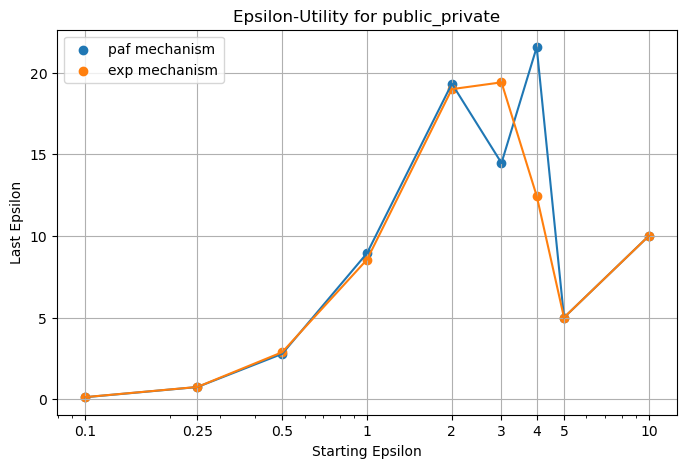

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(epsilons, dist_last_eps_l1_pnp_paf)
plt.scatter(epsilons, dist_last_eps_l1_pnp_paf, label="paf mechanism")
plt.plot(epsilons, dist_last_eps_l1_pnp)
plt.scatter(epsilons, dist_last_eps_l1_pnp, label="exp mechanism")
plt.xscale('log')
plt.xlabel('Starting Epsilon')
plt.ylabel('Last Epsilon')
plt.xticks(epsilons, [str(i) for i in epsilons])
plt.title(f'Epsilon-Utility for public_private')
plt.grid(True)
plt.legend()
plt.show()